In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import math

from collections import OrderedDict


import scanpy as sc
import os


In [2]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )

adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')

In [3]:
class scDataset(Dataset):
    def __init__(self, adata):
        """
        adata: AnnData object
        cat: from adata.obs['sample']
        labels: from adata.obs['leiden_scVI_res0.9'] --> Need to be changed to cell type
        """
        self.obs = adata.obs
        self.data = torch.log(torch.tensor(adata.layers['counts'].toarray() + 1. ))  # log transform
        #self.data =  torch.tensor(adata.layers['counts'].toarray())
        self.local_library_mean = self.data.sum(axis=1)
        self.local_library_var = torch.tensor([1.])
        
        self.cat = torch.tensor(adata.obs['sample'].cat.codes.values).to(torch.int64) # sample labels
        self.n_cat = adata.obs['sample'].nunique()
        self.labels = torch.tensor(adata.obs['leiden_scVI_res0.9'].cat.codes.values).to(torch.int64)   # cell type labels
        self.n_labels = adata.obs['leiden_scVI_res0.9'].nunique()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # onehot encode `cat` and `labels`
        cat_onehot = F.one_hot(self.cat[idx], self.n_cat)
        label_onehot = F.one_hot(self.labels[idx], self.n_labels)
        
        return self.data[idx], cat_onehot, label_onehot, self.local_library_mean[idx], self.local_library_var 
    

# Example
# adipose_dataset = scDataset(adipose_sn_ad)
# data_loader = DataLoader(adipose_dataset, batch_size=10, shuffle=False)
# a = next(iter(data_loader))
    

In [4]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(LinearBlock, self).__init__()
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim, momentum=.01, eps=0.001),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder_x(nn.Module):
    """_summary_
        This encodes the latent space of the data vector x
    Args:
        nn (_type_): _description_
        latent_dim: 1280, same as the latent_dim in the UCE model (UCE: \ref[Rosen, Yanay, et al. "Universal Cell Embeddings: A Foundation Model for Cell Biology." bioRxiv (2023): 2023-11.])
        
    """
    def __init__(self, input_dim, latent_dim=1280, hidden_dim=1280, hidden_layers=1):
        super(Encoder_x, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, cell_type_one_hot=None):
        if cell_type_one_hot is not None:
            x = torch.cat([x, cell_type_one_hot], dim=1) # cell_type_one_hot is the one_hot encoded cell_type_index  
        x = self.layers(x)
        qz_mean = self.linear_mean(x)
        qz_var = torch.exp(self.linear_var(x))
        #z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        return qz_mean, qz_var #, z_dist
    
    
class Encoder_l(nn.Module):
    """_summary_
        This encodes the library size, which is affected by observation x 
        
    Args:
        nn (_type_): _description_
        latent_dim: 1
        
    """
    def __init__(self, input_dim, latent_dim=1, hidden_dim=20, hidden_layers=1):
        super(Encoder_l, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        x = self.layers(x)
        ql_mean = self.linear_mean(x)
        ql_var = torch.exp(self.linear_var(x))
        #library_dist = torch.distributions.Normal(ql_mean, ql_var.sqrt())
        return ql_mean, ql_var #, library_dist
    

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1280, hidden_layers=1):
        super(Decoder, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -1) 
        self.decoder = nn.Sequential(
            *[LinearBlock(dim[0], dim[1], dropout=None) for dim in layer_dims]
        )
        
        self.px_dropout_decoder = nn.Linear(hidden_dim, output_dim)  # the logit of the dropout rate
        self.px_scale_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Softmax(dim=-1))
        self.px_dispersion_decoder = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, z, library, cat_one_hot):
        
        input = torch.cat([z, cat_one_hot], dim=1) # cat_index is the one_hot encoded cell_type_index
        x = self.decoder(input)
        
        px_scale = self.px_scale_decoder(x)
        #px_rate = torch.exp(library) * px_scale  # encode library size
        px_rate = library * px_scale  # use observed library size

        
        px_dispersion = self.px_dispersion_decoder(x)
        px_dropout = self.px_dropout_decoder(x)
        
        px_dispersion = torch.exp(px_dispersion)  # positive value
        
        return px_rate, px_dispersion, px_dropout 
    
    

    
def log_zinb_positive(
    x: torch.Tensor,
    mu: torch.Tensor,
    theta: torch.Tensor,
    pi: torch.Tensor,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Adapted From `https://github.com/scverse/scvi-tools`  with minor modifications
     
    Log likelihood (scalar) of a minibatch according to a zinb model.

    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant

    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless
    # of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(1, theta.size(0))  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)
    

    # print(f"x[0, 0] is: {x[0,0]}")
    # print(f"torch.lgamma(x + theta)[0, 0] is: {torch.lgamma(x + theta)[0,0]}")
    # print(f"torch.lgamma(theta)[0, 0] is: {torch.lgamma(theta)[0,0]}")

    res = mul_case_zero + mul_case_non_zero

    return res



def log_nb_positive(
    x: torch.Tensor ,
    mu: torch.Tensor ,
    theta: torch.Tensor ,
    eps: float = 1e-8,
    log_fn: callable = torch.log,
    lgamma_fn: callable = torch.lgamma,
) -> torch.Tensor :
    """Log likelihood (scalar) of a minibatch according to a nb model.

    Parameters
    ----------
    x
        data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    log_fn
        log function
    lgamma_fn
        log gamma function
    """
    log = log_fn
    lgamma = lgamma_fn
    log_theta_mu_eps = log(theta + mu + eps)
    res = (
        theta * (log(theta + eps) - log_theta_mu_eps)
        + x * (log(mu + eps) - log_theta_mu_eps)
        + lgamma(x + theta)
        - lgamma(theta)
        - lgamma(x + 1)
    )

    return res


In [35]:
class snRNAseqVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, total_cat, total_cell_type, cell_type_encode=True):
        super(snRNAseqVAE, self).__init__()

        self.cell_type_encode = cell_type_encode 
        
        self.total_cat = total_cat
        self.total_cell_type = total_cell_type # total_cell_type = total-known-cell-types + 1 (for unknown cell type: 0) 
                
        if cell_type_encode:
            encoder_x_input_dim = input_dim + total_cell_type
        else:
            encoder_x_input_dim = input_dim
        self.encoder_x = Encoder_x(encoder_x_input_dim, latent_dim, hidden_dim=128,  hidden_layers=1)
        
        #self.encoder_l = Encoder_l(input_dim, 1)
        
        decoder_input_dim = latent_dim + total_cat  # total_cat is the total number of categories in the cat_index, indicates datasets 
        self.decoder = Decoder(decoder_input_dim, output_dim, hidden_dim=128, hidden_layers=1)
        
    def _inference(self, x, cat_one_hot, cell_type_one_hot, l):
        if self.cell_type_encode:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)
        else:
            qz_mean, qz_var = self.encoder_x(x)
        #ql_mean, ql_var = self.encoder_l(x)
        z = torch.distributions.Normal(qz_mean, qz_var.sqrt()).rsample()
        #l = torch.distributions.Normal(ql_mean, ql_var.sqrt()).rsample()
        px_rate, px_dispersion, px_dropout  = self.decoder(z, l, cat_one_hot)
        #return qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout  # encode library size 
        return qz_mean, qz_var, px_rate, px_dispersion, px_dropout 
    
    
    def forward(self, x, local_l_mean, local_l_var, cat_one_hot, cell_type_one_hot):
        """_summary_

        Args:
            x (_type_): _description_
            local_l_mean (_type_): shape of [batch_size, 1]
            local_l_var (_type_): shape of [batch_size, 1]
            cat_one_hot (_type_): shape of [batch_size, n_cat]
            cell_type_one_hot (_type_): shape of [batch_size, n_cell_types]

        Returns:
            _type_: _description_
        """
        #local_l_mean =  x.sum(axis=1) outside of this function
        #local_l_var = 0 # should this be within batch? YES as it is observed and varies from batch to batch. FInish outside of this function

        
        #qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)  # encode library size output 
        qz_mean, qz_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)
        z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        #l_dist = torch.distributions.Normal(ql_mean, ql_var)

        kl_z = torch.distributions.kl.kl_divergence(z_dist, torch.distributions.Normal(torch.zeros_like(qz_mean), torch.ones_like(qz_var))).sum(axis=1)
        #kl_l = torch.distributions.kl.kl_divergence(l_dist, torch.distributions.Normal(local_l_mean, local_l_var.sqrt())).sum(axis=1)
        
        reconst_loss = -log_zinb_positive(x, px_rate, px_dispersion, px_dropout).sum(axis=-1)

        return (reconst_loss + kl_z ).mean() #, reconst_loss.mean(), kl_z.mean(), kl_l.mean()
        #return (reconst_loss + kl_z ).mean()

#### Change to code cell to run 
#### DEBUGGING
###### prepare data
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, total_cat=total_cat, total_cell_type=total_cell_type)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01)

x, cat_onehot, label_onehot, local_library_mean, local_library_var = next(iter(data_loader))

loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot)

for i in loss:
    print(i)

In [36]:
## Training 
def trainning(model, train_loader, device, optimizer, n_epochs=100):
    model = model.to(device)
    model.train()
    train_loss = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        N = 0
        for i, data in enumerate(train_loader):
            x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
            
            x = x.to(device)
            cat_onehot = cat_onehot.to(device)
            label_onehot = label_onehot.to(device)
            local_library_mean = local_library_mean.to(device).view((-1,1))  # size of [batch_size, 1]
            local_library_var = local_library_var.to(device).view((-1,1))  # size of [batch_size, 1]
            
            optimizer.zero_grad()
            loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot) 
            loss.backward()
            total_loss += loss.item() * x.size(0)
            N += x.size(0)
            optimizer.step()
        print("Epoch: ", epoch, "Loss: ", total_loss/N )
        train_loss.append(total_loss/N)
        
    return train_loss

In [37]:
## Data
train_data = adipose_sn_ad#[adipose_sn_ad.obs['sample'] == '03_SQ', ]
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=True)

## set model 
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=10, total_cat=total_cat, total_cell_type=total_cell_type, cell_type_encode=False)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01)

train_loss = trainning(model, data_loader, device='cuda', optimizer=optimizer, n_epochs=200)

  0%|          | 1/200 [00:04<14:08,  4.26s/it]

Epoch:  0 Loss:  3733.2904992264307


  1%|          | 2/200 [00:08<14:04,  4.26s/it]

Epoch:  1 Loss:  3259.5371306344364


  2%|▏         | 3/200 [00:12<14:08,  4.31s/it]

Epoch:  2 Loss:  3134.240422280987


  2%|▏         | 4/200 [00:17<14:01,  4.29s/it]

Epoch:  3 Loss:  3071.872749928678


  2%|▎         | 5/200 [00:21<13:58,  4.30s/it]

Epoch:  4 Loss:  3040.8525404340767


  3%|▎         | 6/200 [00:25<13:52,  4.29s/it]

Epoch:  5 Loss:  3020.817500768083


  4%|▎         | 7/200 [00:30<13:47,  4.29s/it]

Epoch:  6 Loss:  3007.01372742385


  4%|▍         | 8/200 [00:34<13:42,  4.28s/it]

Epoch:  7 Loss:  2996.682191312983


  4%|▍         | 9/200 [00:38<13:38,  4.28s/it]

Epoch:  8 Loss:  2988.7293618877284


  5%|▌         | 10/200 [00:42<13:33,  4.28s/it]

Epoch:  9 Loss:  2982.25830078125


  6%|▌         | 11/200 [00:47<13:28,  4.28s/it]

Epoch:  10 Loss:  2976.8607006287307


  6%|▌         | 12/200 [00:51<13:24,  4.28s/it]

Epoch:  11 Loss:  2971.91468176681


  6%|▋         | 13/200 [00:55<13:20,  4.28s/it]

Epoch:  12 Loss:  2967.7053016919767


  7%|▋         | 14/200 [00:59<13:16,  4.28s/it]

Epoch:  13 Loss:  2964.510888260402


  8%|▊         | 15/200 [01:04<13:11,  4.28s/it]

Epoch:  14 Loss:  2960.803995539633


  8%|▊         | 16/200 [01:08<13:07,  4.28s/it]

Epoch:  15 Loss:  2958.2088300726386


  8%|▊         | 17/200 [01:12<13:02,  4.28s/it]

Epoch:  16 Loss:  2956.2507639681357


  9%|▉         | 18/200 [01:17<12:58,  4.28s/it]

Epoch:  17 Loss:  2953.744221548016


 10%|▉         | 19/200 [01:21<12:53,  4.27s/it]

Epoch:  18 Loss:  2951.760740130135


 10%|█         | 20/200 [01:25<12:48,  4.27s/it]

Epoch:  19 Loss:  2950.4021716171437


 10%|█         | 21/200 [01:29<12:44,  4.27s/it]

Epoch:  20 Loss:  2948.6377069709006


 11%|█         | 22/200 [01:34<12:39,  4.27s/it]

Epoch:  21 Loss:  2947.2196264374124


 12%|█▏        | 23/200 [01:38<12:35,  4.27s/it]

Epoch:  22 Loss:  2945.6619139253426


 12%|█▏        | 24/200 [01:42<12:31,  4.27s/it]

Epoch:  23 Loss:  2944.2795471877193


 12%|█▎        | 25/200 [01:46<12:27,  4.27s/it]

Epoch:  24 Loss:  2943.3949207777387


 13%|█▎        | 26/200 [01:51<12:22,  4.27s/it]

Epoch:  25 Loss:  2942.047078679117


 14%|█▎        | 27/200 [01:55<12:17,  4.26s/it]

Epoch:  26 Loss:  2940.7401849982443


 14%|█▍        | 28/200 [01:59<12:13,  4.26s/it]

Epoch:  27 Loss:  2940.1522011060392


 14%|█▍        | 29/200 [02:04<12:09,  4.26s/it]

Epoch:  28 Loss:  2938.677829013782


 15%|█▌        | 30/200 [02:08<12:04,  4.26s/it]

Epoch:  29 Loss:  2937.9770089481653


 16%|█▌        | 31/200 [02:12<12:00,  4.26s/it]

Epoch:  30 Loss:  2936.9793351419858


 16%|█▌        | 32/200 [02:16<11:55,  4.26s/it]

Epoch:  31 Loss:  2935.9645954946454


 16%|█▋        | 33/200 [02:21<11:51,  4.26s/it]

Epoch:  32 Loss:  2935.5561715458216


 17%|█▋        | 34/200 [02:25<11:46,  4.26s/it]

Epoch:  33 Loss:  2934.4663497410465


 18%|█▊        | 35/200 [02:29<11:43,  4.26s/it]

Epoch:  34 Loss:  2934.0774206954443


 18%|█▊        | 36/200 [02:33<11:38,  4.26s/it]

Epoch:  35 Loss:  2933.3628930938376


 18%|█▊        | 37/200 [02:38<11:34,  4.26s/it]

Epoch:  36 Loss:  2932.623715518566


 19%|█▉        | 38/200 [02:42<11:29,  4.26s/it]

Epoch:  37 Loss:  2932.0272312807233


 20%|█▉        | 39/200 [02:46<11:24,  4.25s/it]

Epoch:  38 Loss:  2931.561760720242


 20%|██        | 40/200 [02:50<11:20,  4.25s/it]

Epoch:  39 Loss:  2931.2429288371227


 20%|██        | 41/200 [02:55<11:16,  4.25s/it]

Epoch:  40 Loss:  2930.1896636619995


 21%|██        | 42/200 [02:59<11:11,  4.25s/it]

Epoch:  41 Loss:  2929.9614196091557


 22%|██▏       | 43/200 [03:03<11:08,  4.26s/it]

Epoch:  42 Loss:  2929.35293201918


 22%|██▏       | 44/200 [03:07<11:03,  4.25s/it]

Epoch:  43 Loss:  2929.303748655855


 22%|██▎       | 45/200 [03:12<10:59,  4.25s/it]

Epoch:  44 Loss:  2928.5615700711023


 23%|██▎       | 46/200 [03:16<10:55,  4.26s/it]

Epoch:  45 Loss:  2928.522202395321


 24%|██▎       | 47/200 [03:20<10:51,  4.26s/it]

Epoch:  46 Loss:  2927.176546589712


 24%|██▍       | 48/200 [03:24<10:47,  4.26s/it]

Epoch:  47 Loss:  2926.93201780855


 24%|██▍       | 49/200 [03:29<10:43,  4.26s/it]

Epoch:  48 Loss:  2926.584769602572


 25%|██▌       | 50/200 [03:33<10:39,  4.26s/it]

Epoch:  49 Loss:  2926.084212742495


 26%|██▌       | 51/200 [03:37<10:35,  4.26s/it]

Epoch:  50 Loss:  2925.826491452335


 26%|██▌       | 52/200 [03:42<10:37,  4.31s/it]

Epoch:  51 Loss:  2925.3397347096648


 26%|██▋       | 53/200 [03:46<10:30,  4.29s/it]

Epoch:  52 Loss:  2925.2958188860603


 27%|██▋       | 54/200 [03:50<10:25,  4.28s/it]

Epoch:  53 Loss:  2924.9759116869295


 28%|██▊       | 55/200 [03:54<10:19,  4.28s/it]

Epoch:  54 Loss:  2924.1790538316363


 28%|██▊       | 56/200 [03:59<10:15,  4.27s/it]

Epoch:  55 Loss:  2923.6982888211023


 28%|██▊       | 57/200 [04:03<10:10,  4.27s/it]

Epoch:  56 Loss:  2923.059647806575


 29%|██▉       | 58/200 [04:07<10:05,  4.26s/it]

Epoch:  57 Loss:  2923.37073645431


 30%|██▉       | 59/200 [04:11<10:01,  4.26s/it]

Epoch:  58 Loss:  2922.664668736833


 30%|███       | 60/200 [04:16<09:59,  4.28s/it]

Epoch:  59 Loss:  2922.641277184647


 30%|███       | 61/200 [04:20<09:53,  4.27s/it]

Epoch:  60 Loss:  2922.2471526070926


 31%|███       | 62/200 [04:24<09:48,  4.26s/it]

Epoch:  61 Loss:  2921.8459959565926


 32%|███▏      | 63/200 [04:28<09:43,  4.26s/it]

Epoch:  62 Loss:  2921.625155673938


 32%|███▏      | 64/200 [04:33<09:38,  4.25s/it]

Epoch:  63 Loss:  2921.2948862140097


 32%|███▎      | 65/200 [04:37<09:33,  4.25s/it]

Epoch:  64 Loss:  2920.916772735253


 33%|███▎      | 66/200 [04:41<09:29,  4.25s/it]

Epoch:  65 Loss:  2920.784177630135


 34%|███▎      | 67/200 [04:45<09:24,  4.24s/it]

Epoch:  66 Loss:  2920.38052196717


 34%|███▍      | 68/200 [04:50<09:19,  4.24s/it]

Epoch:  67 Loss:  2920.3482213395364


 34%|███▍      | 69/200 [04:54<09:14,  4.24s/it]

Epoch:  68 Loss:  2919.9192943787307


 35%|███▌      | 70/200 [04:58<09:10,  4.23s/it]

Epoch:  69 Loss:  2919.8266471262727


 36%|███▌      | 71/200 [05:02<09:05,  4.23s/it]

Epoch:  70 Loss:  2919.3912202642205


 36%|███▌      | 72/200 [05:07<09:01,  4.23s/it]

Epoch:  71 Loss:  2919.5959966423807


 36%|███▋      | 73/200 [05:11<08:57,  4.23s/it]

Epoch:  72 Loss:  2918.9134754652387


 37%|███▋      | 74/200 [05:15<08:53,  4.24s/it]

Epoch:  73 Loss:  2918.8509747794506


 38%|███▊      | 75/200 [05:19<08:49,  4.23s/it]

Epoch:  74 Loss:  2918.425688668583


 38%|███▊      | 76/200 [05:24<08:44,  4.23s/it]

Epoch:  75 Loss:  2918.2450273492364


 38%|███▊      | 77/200 [05:28<08:40,  4.23s/it]

Epoch:  76 Loss:  2918.0315627194523


 39%|███▉      | 78/200 [05:32<08:36,  4.23s/it]

Epoch:  77 Loss:  2917.4189974324086


 40%|███▉      | 79/200 [05:36<08:32,  4.23s/it]

Epoch:  78 Loss:  2917.042151290379


 40%|████      | 80/200 [05:40<08:28,  4.24s/it]

Epoch:  79 Loss:  2916.7580442964363


 40%|████      | 81/200 [05:45<08:23,  4.24s/it]

Epoch:  80 Loss:  2916.672743207953


 41%|████      | 82/200 [05:49<08:19,  4.23s/it]

Epoch:  81 Loss:  2916.8758620358585


 42%|████▏     | 83/200 [05:53<08:15,  4.24s/it]

Epoch:  82 Loss:  2916.0771895847965


 42%|████▏     | 84/200 [05:57<08:11,  4.24s/it]

Epoch:  83 Loss:  2916.496134211508


 42%|████▎     | 85/200 [06:02<08:07,  4.24s/it]

Epoch:  84 Loss:  2915.861956992846


 43%|████▎     | 86/200 [06:06<08:02,  4.24s/it]

Epoch:  85 Loss:  2915.6867463186886


 44%|████▎     | 87/200 [06:10<07:58,  4.23s/it]

Epoch:  86 Loss:  2915.497742385007


 44%|████▍     | 88/200 [06:14<07:54,  4.24s/it]

Epoch:  87 Loss:  2915.4655343387903


 44%|████▍     | 89/200 [06:19<07:50,  4.24s/it]

Epoch:  88 Loss:  2914.460434131408


 45%|████▌     | 90/200 [06:23<07:46,  4.24s/it]

Epoch:  89 Loss:  2914.493960262684


 46%|████▌     | 91/200 [06:27<07:41,  4.24s/it]

Epoch:  90 Loss:  2914.8261513013517


 46%|████▌     | 92/200 [06:31<07:37,  4.24s/it]

Epoch:  91 Loss:  2914.355966632286


 46%|████▋     | 93/200 [06:36<07:32,  4.23s/it]

Epoch:  92 Loss:  2913.864622651861


 47%|████▋     | 94/200 [06:40<07:28,  4.23s/it]

Epoch:  93 Loss:  2913.4763793945312


 48%|████▊     | 95/200 [06:44<07:24,  4.23s/it]

Epoch:  94 Loss:  2913.7511850421347


 48%|████▊     | 96/200 [06:48<07:19,  4.23s/it]

Epoch:  95 Loss:  2913.3111880870347


 48%|████▊     | 97/200 [06:52<07:15,  4.23s/it]

Epoch:  96 Loss:  2913.4311989773523


 49%|████▉     | 98/200 [06:57<07:11,  4.23s/it]

Epoch:  97 Loss:  2912.890836222788


 50%|████▉     | 99/200 [07:01<07:07,  4.23s/it]

Epoch:  98 Loss:  2911.397178392732


 50%|█████     | 100/200 [07:05<07:03,  4.23s/it]

Epoch:  99 Loss:  2912.0376586914062


 50%|█████     | 101/200 [07:09<06:58,  4.23s/it]

Epoch:  100 Loss:  2912.2430365058813


 51%|█████     | 102/200 [07:14<06:55,  4.23s/it]

Epoch:  101 Loss:  2912.0746754849893


 52%|█████▏    | 103/200 [07:18<06:50,  4.23s/it]

Epoch:  102 Loss:  2910.728246795997


 52%|█████▏    | 104/200 [07:22<06:50,  4.28s/it]

Epoch:  103 Loss:  2911.1869822298545


 52%|█████▎    | 105/200 [07:27<06:48,  4.30s/it]

Epoch:  104 Loss:  2911.4151508459886


 53%|█████▎    | 106/200 [07:31<06:42,  4.28s/it]

Epoch:  105 Loss:  2910.2645915170733


 54%|█████▎    | 107/200 [07:35<06:36,  4.27s/it]

Epoch:  106 Loss:  2909.699251667837


 54%|█████▍    | 108/200 [07:39<06:31,  4.26s/it]

Epoch:  107 Loss:  2910.904381912746


 55%|█████▍    | 109/200 [07:44<06:27,  4.26s/it]

Epoch:  108 Loss:  2910.272994480776


 55%|█████▌    | 110/200 [07:48<06:22,  4.25s/it]

Epoch:  109 Loss:  2910.4910333183375


 56%|█████▌    | 111/200 [07:52<06:17,  4.25s/it]

Epoch:  110 Loss:  2909.68549132615


 56%|█████▌    | 112/200 [07:56<06:13,  4.24s/it]

Epoch:  111 Loss:  2910.099121779538


 56%|█████▋    | 113/200 [08:00<06:08,  4.24s/it]

Epoch:  112 Loss:  2908.8573951292574


 57%|█████▋    | 114/200 [08:05<06:04,  4.24s/it]

Epoch:  113 Loss:  2908.638241199965


 57%|█████▊    | 115/200 [08:09<05:59,  4.23s/it]

Epoch:  114 Loss:  2908.353997048367


 58%|█████▊    | 116/200 [08:13<05:55,  4.23s/it]

Epoch:  115 Loss:  2909.0371704101562


 58%|█████▊    | 117/200 [08:17<05:51,  4.23s/it]

Epoch:  116 Loss:  2908.1850099027824


 59%|█████▉    | 118/200 [08:22<05:47,  4.24s/it]

Epoch:  117 Loss:  2907.8412887058903


 60%|█████▉    | 119/200 [08:26<05:43,  4.24s/it]

Epoch:  118 Loss:  2907.7101255266853


 60%|██████    | 120/200 [08:30<05:38,  4.24s/it]

Epoch:  119 Loss:  2908.602005519224


 60%|██████    | 121/200 [08:34<05:34,  4.24s/it]

Epoch:  120 Loss:  2908.3196925474017


 61%|██████    | 122/200 [08:39<05:31,  4.25s/it]

Epoch:  121 Loss:  2907.8846353252284


 62%|██████▏   | 123/200 [08:43<05:27,  4.25s/it]

Epoch:  122 Loss:  2907.959347156996


 62%|██████▏   | 124/200 [08:47<05:22,  4.25s/it]

Epoch:  123 Loss:  2907.779775555214


 62%|██████▎   | 125/200 [08:51<05:18,  4.24s/it]

Epoch:  124 Loss:  2907.7537190298017


 63%|██████▎   | 126/200 [08:56<05:13,  4.24s/it]

Epoch:  125 Loss:  2907.831337232268


 64%|██████▎   | 127/200 [09:00<05:09,  4.24s/it]

Epoch:  126 Loss:  2907.563986788975


 64%|██████▍   | 128/200 [09:04<05:05,  4.24s/it]

Epoch:  127 Loss:  2907.10672717148


 64%|██████▍   | 129/200 [09:08<05:00,  4.24s/it]

Epoch:  128 Loss:  2907.419443880574


 65%|██████▌   | 130/200 [09:13<04:56,  4.24s/it]

Epoch:  129 Loss:  2907.5761300419153


 66%|██████▌   | 131/200 [09:17<04:52,  4.24s/it]

Epoch:  130 Loss:  2907.296521133251


 66%|██████▌   | 132/200 [09:21<04:47,  4.23s/it]

Epoch:  131 Loss:  2906.485293956285


 66%|██████▋   | 133/200 [09:25<04:43,  4.23s/it]

Epoch:  132 Loss:  2907.056522669417


 67%|██████▋   | 134/200 [09:29<04:39,  4.23s/it]

Epoch:  133 Loss:  2906.90138296063


 68%|██████▊   | 135/200 [09:34<04:35,  4.23s/it]

Epoch:  134 Loss:  2906.8515810162835


 68%|██████▊   | 136/200 [09:38<04:30,  4.23s/it]

Epoch:  135 Loss:  2906.65634532457


 68%|██████▊   | 137/200 [09:42<04:26,  4.23s/it]

Epoch:  136 Loss:  2905.988364230381


 69%|██████▉   | 138/200 [09:46<04:22,  4.23s/it]

Epoch:  137 Loss:  2906.783635171612


 70%|██████▉   | 139/200 [09:51<04:18,  4.23s/it]

Epoch:  138 Loss:  2905.4237787482443


 70%|███████   | 140/200 [09:55<04:13,  4.23s/it]

Epoch:  139 Loss:  2905.5592095878687


 70%|███████   | 141/200 [09:59<04:09,  4.23s/it]

Epoch:  140 Loss:  2905.327150494865


 71%|███████   | 142/200 [10:03<04:05,  4.23s/it]

Epoch:  141 Loss:  2905.5313268082864


 72%|███████▏  | 143/200 [10:08<04:01,  4.23s/it]

Epoch:  142 Loss:  2905.322092120567


 72%|███████▏  | 144/200 [10:12<03:57,  4.23s/it]

Epoch:  143 Loss:  2904.98405748003


 72%|███████▎  | 145/200 [10:16<03:53,  4.24s/it]

Epoch:  144 Loss:  2904.7890158663977


 73%|███████▎  | 146/200 [10:20<03:48,  4.24s/it]

Epoch:  145 Loss:  2903.949805098973


 74%|███████▎  | 147/200 [10:24<03:44,  4.24s/it]

Epoch:  146 Loss:  2904.098091725553


 74%|███████▍  | 148/200 [10:29<03:40,  4.24s/it]

Epoch:  147 Loss:  2904.485090277168


 74%|███████▍  | 149/200 [10:33<03:36,  4.24s/it]

Epoch:  148 Loss:  2904.2708267040466


 75%|███████▌  | 150/200 [10:37<03:31,  4.24s/it]

Epoch:  149 Loss:  2904.1461401092874


 76%|███████▌  | 151/200 [10:41<03:27,  4.23s/it]

Epoch:  150 Loss:  2904.3144394092346


 76%|███████▌  | 152/200 [10:46<03:23,  4.23s/it]

Epoch:  151 Loss:  2903.8787286308375


 76%|███████▋  | 153/200 [10:50<03:18,  4.23s/it]

Epoch:  152 Loss:  2903.8190568216733


 77%|███████▋  | 154/200 [10:54<03:14,  4.24s/it]

Epoch:  153 Loss:  2904.7091489641853


 78%|███████▊  | 155/200 [10:58<03:11,  4.25s/it]

Epoch:  154 Loss:  2904.9156878182057


 78%|███████▊  | 156/200 [11:03<03:08,  4.29s/it]

Epoch:  155 Loss:  2903.9778730413886


 78%|███████▊  | 157/200 [11:07<03:03,  4.27s/it]

Epoch:  156 Loss:  2904.54522362184


 79%|███████▉  | 158/200 [11:11<02:58,  4.26s/it]

Epoch:  157 Loss:  2903.732303233629


 80%|███████▉  | 159/200 [11:15<02:54,  4.25s/it]

Epoch:  158 Loss:  2902.824530783664


 80%|████████  | 160/200 [11:20<02:49,  4.25s/it]

Epoch:  159 Loss:  2905.564184295997


 80%|████████  | 161/200 [11:24<02:45,  4.25s/it]

Epoch:  160 Loss:  2904.187758542179


 81%|████████  | 162/200 [11:28<02:41,  4.25s/it]

Epoch:  161 Loss:  2904.3632469605864


 82%|████████▏ | 163/200 [11:32<02:36,  4.24s/it]

Epoch:  162 Loss:  2903.2775824043188


 82%|████████▏ | 164/200 [11:37<02:32,  4.24s/it]

Epoch:  163 Loss:  2904.207363171524


 82%|████████▎ | 165/200 [11:41<02:28,  4.24s/it]

Epoch:  164 Loss:  2903.2255338175914


 83%|████████▎ | 166/200 [11:45<02:23,  4.23s/it]

Epoch:  165 Loss:  2902.554370665818


 84%|████████▎ | 167/200 [11:49<02:19,  4.23s/it]

Epoch:  166 Loss:  2903.664243548104


 84%|████████▍ | 168/200 [11:54<02:15,  4.23s/it]

Epoch:  167 Loss:  2902.2684374177056


 84%|████████▍ | 169/200 [11:58<02:11,  4.23s/it]

Epoch:  168 Loss:  2902.8513876239904


 85%|████████▌ | 170/200 [12:02<02:07,  4.24s/it]

Epoch:  169 Loss:  2903.804026400105


 86%|████████▌ | 171/200 [12:06<02:02,  4.24s/it]

Epoch:  170 Loss:  2901.8409499264835


 86%|████████▌ | 172/200 [12:11<01:58,  4.24s/it]

Epoch:  171 Loss:  2902.3100325337955


 86%|████████▋ | 173/200 [12:15<01:54,  4.24s/it]

Epoch:  172 Loss:  2903.042267188597


 87%|████████▋ | 174/200 [12:19<01:50,  4.23s/it]

Epoch:  173 Loss:  2903.0943733815398


 88%|████████▊ | 175/200 [12:23<01:45,  4.24s/it]

Epoch:  174 Loss:  2903.491012744689


 88%|████████▊ | 176/200 [12:27<01:41,  4.24s/it]

Epoch:  175 Loss:  2902.669760714756


 88%|████████▊ | 177/200 [12:32<01:37,  4.24s/it]

Epoch:  176 Loss:  2901.8852977966994


 89%|████████▉ | 178/200 [12:36<01:33,  4.23s/it]

Epoch:  177 Loss:  2902.899839251229


 90%|████████▉ | 179/200 [12:40<01:28,  4.23s/it]

Epoch:  178 Loss:  2901.8025121796


 90%|█████████ | 180/200 [12:44<01:24,  4.23s/it]

Epoch:  179 Loss:  2902.3789858014397


 90%|█████████ | 181/200 [12:49<01:20,  4.23s/it]

Epoch:  180 Loss:  2902.723130129696


 91%|█████████ | 182/200 [12:53<01:16,  4.23s/it]

Epoch:  181 Loss:  2903.3998762837955


 92%|█████████▏| 183/200 [12:57<01:11,  4.23s/it]

Epoch:  182 Loss:  2901.6387315385796


 92%|█████████▏| 184/200 [13:01<01:07,  4.23s/it]

Epoch:  183 Loss:  2900.9446369985517


 92%|█████████▎| 185/200 [13:06<01:03,  4.23s/it]

Epoch:  184 Loss:  2901.6503481061272


 93%|█████████▎| 186/200 [13:10<00:59,  4.23s/it]

Epoch:  185 Loss:  2902.4679112809426


 94%|█████████▎| 187/200 [13:14<00:54,  4.23s/it]

Epoch:  186 Loss:  2901.7929337747983


 94%|█████████▍| 188/200 [13:18<00:50,  4.23s/it]

Epoch:  187 Loss:  2900.6398514308285


 94%|█████████▍| 189/200 [13:23<00:46,  4.23s/it]

Epoch:  188 Loss:  2901.911918040072


 95%|█████████▌| 190/200 [13:27<00:42,  4.23s/it]

Epoch:  189 Loss:  2902.179153956724


 96%|█████████▌| 191/200 [13:31<00:38,  4.24s/it]

Epoch:  190 Loss:  2903.7795204419767


 96%|█████████▌| 192/200 [13:35<00:33,  4.23s/it]

Epoch:  191 Loss:  2902.8173944709006


 96%|█████████▋| 193/200 [13:39<00:29,  4.24s/it]

Epoch:  192 Loss:  2902.3160482685216


 97%|█████████▋| 194/200 [13:44<00:25,  4.23s/it]

Epoch:  193 Loss:  2901.3991438619205


 98%|█████████▊| 195/200 [13:48<00:21,  4.23s/it]

Epoch:  194 Loss:  2901.018255683813


 98%|█████████▊| 196/200 [13:52<00:16,  4.23s/it]

Epoch:  195 Loss:  2901.7877327565398


 98%|█████████▊| 197/200 [13:56<00:12,  4.23s/it]

Epoch:  196 Loss:  2901.9451924870523


 99%|█████████▉| 198/200 [14:01<00:08,  4.24s/it]

Epoch:  197 Loss:  2901.1121647866926


100%|█████████▉| 199/200 [14:05<00:04,  4.24s/it]

Epoch:  198 Loss:  2902.23717370194


100%|██████████| 200/200 [14:09<00:00,  4.25s/it]

Epoch:  199 Loss:  2899.9333694972347


In [38]:
# Get latent representation of the data
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        #qz_mean, _ = model.encoder_x(x, label_onehot)
        qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [39]:
train_data_2 = train_data.copy()
train_data_2.obsm['syy_VAE'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE')
sc.tl.umap(train_data_2)

In [40]:
train_data_2.obsm['syy_VAE'].shape

(71200, 10)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


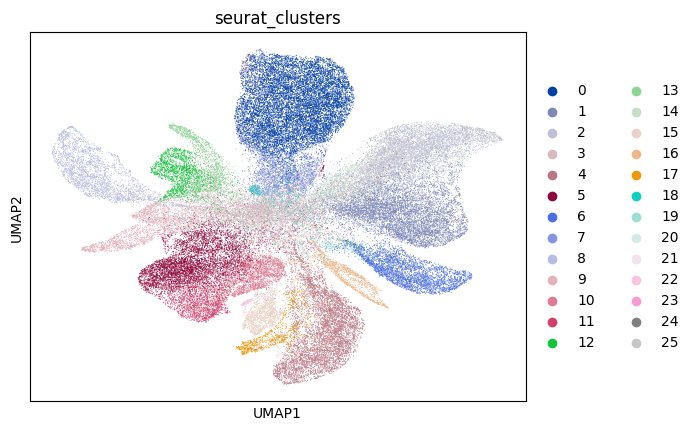

In [41]:
sc.pl.umap(train_data_2, color=['seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


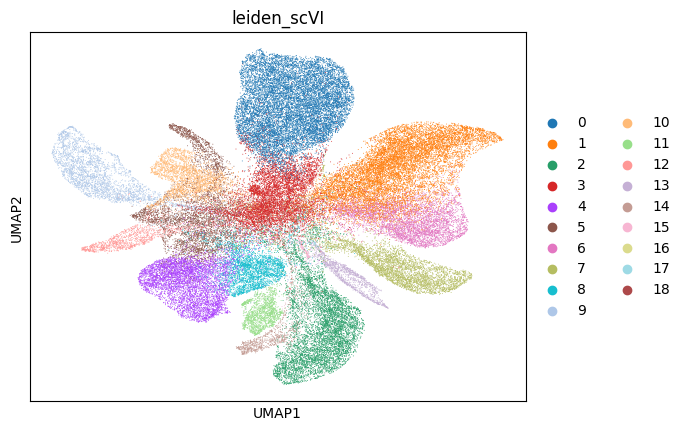

In [42]:
sc.pl.umap(train_data_2, color=['leiden_scVI'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


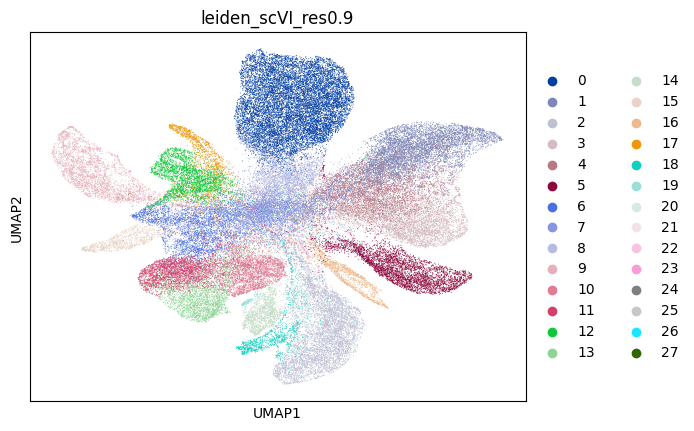

In [43]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

In [32]:
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        #qz_mean, _ = model.encoder_x(x, label_onehot)
        qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [33]:
train_data_2.obsm['syy_VAE300epo'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE300epo')
sc.tl.umap(train_data_2)

## SCVI's results as reference

In [97]:
sc.pp.neighbors(train_data, use_rep='X_scVI')
sc.tl.umap(train_data)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


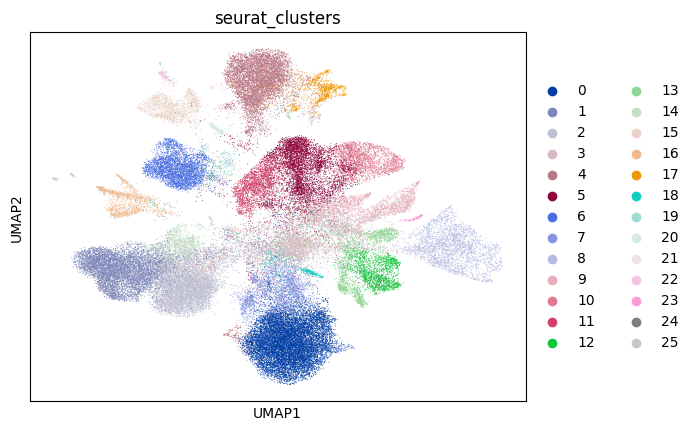

In [98]:
sc.pl.umap(train_data, color=['seurat_clusters'] )

In [60]:
#adipose_sn_ad_sp2.write_h5ad("/home/syyang/GitRepo/cs294/finalproject/script/adipose_with_VAE20270427.h5ad")

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


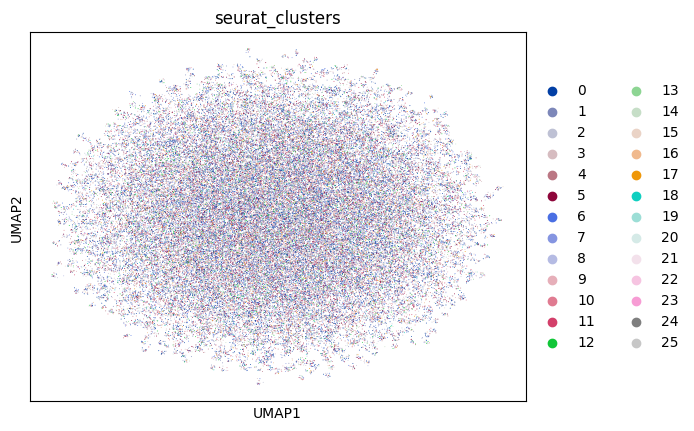

In [34]:
sc.pl.umap(adipose_sn_ad_sp2, color=['seurat_clusters'] )